In [53]:
# Install Surprise library
!pip install scikit-surprise

In [75]:
# Import required libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_excel("Online Retail.xlsx")

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df = df[['CustomerID', 'StockCode', 'Quantity']]

# Aggregate purchase frequency as ratings
df = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()

# Normalize ratings to a scale of 1-5
df['rating'] = pd.cut(df['Quantity'], bins=[0, 1, 5, 10, 20, float('inf')], labels=[1, 2, 3, 4, 5])
df = df.drop(columns=['Quantity'])

df.head()


,CustomerID,StockCode,rating
0,12346.0,23166,NaN
1,12347.0,16008,5
2,12347.0,17021,5
3,12347.0,20665,3
4,12347.0,20719,5


In [55]:
# Define rating scale and load data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['CustomerID', 'StockCode', 'rating']], reader)

# Train and evaluate the model as before
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
algo.fit(trainset)

# Evaluate the model
predictions = algo.test(testset)
accuracy.rmse(predictions)


RMSE: nan


nan

In [56]:
# Function to recommend top-N products for a user
def recommend_products(user_id, algo, n=5):
    all_products = df['StockCode'].unique()
    rated_products = df[df['CustomerID'] == user_id]['StockCode'].unique()

    # Predict ratings for products not yet rated by the user
    recommendations = []
    for product in all_products:
        if product not in rated_products:
            pred = algo.predict(user_id, product)
            recommendations.append((product, pred.est))
    
    # Sort by predicted rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [product for product, _ in recommendations]

# Get recommendations for a user
user_id = 17850  # Example user ID from dataset
recommended_products = recommend_products(user_id, algo)
print(f"Recommended Products for User {user_id}: {recommended_products}")


Recommended Products for User 17850: [23166, 16008, 17021, 20665, 20719]


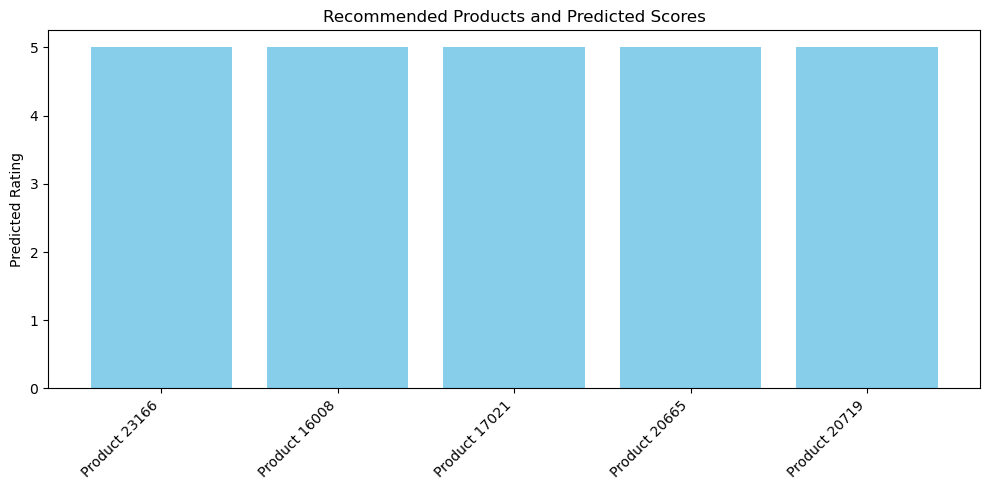

In [57]:
import matplotlib.pyplot as plt

# Mock product descriptions (replace with real descriptions from the dataset)
product_descriptions = {
    '85048': "White Hanging Heart T-Light Holder",
    '71053': "Mini Glass Bottles in Wooden Box",
    '84406B': "Cream Cupid Hearts Coat Hanger",
    '84406G': "Knitted Union Jack Cushion Cover",
    '22139': "Box of Vintage Alphabet Blocks"
}

# Visualize recommendations
labels = [product_descriptions.get(str(pid), f"Product {pid}") for pid in recommended_products]
scores = [algo.predict(user_id, pid).est for pid in recommended_products]

plt.figure(figsize=(10, 5))
plt.bar(labels, scores, color='skyblue')
plt.title("Recommended Products and Predicted Scores")
plt.ylabel("Predicted Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Example: Content-based filtering using product descriptions
product_metadata = pd.DataFrame({
    'StockCode': ['101', '102', '103'],
    'Description': ['Wireless Mouse', 'Gaming Keyboard', 'Fitness Tracker']
})

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(product_metadata['Description'])

# Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Get similar products
def get_similar_products(product_id, metadata, similarity_matrix):
    idx = metadata[metadata['StockCode'] == product_id].index[0]
    similar_indices = similarity_matrix[idx].argsort()[-3:][::-1]  # Top 3 similar products
    similar_items = metadata.iloc[similar_indices]['StockCode']
    return similar_items.tolist()

# Example: Find products similar to '101'
similar_products = get_similar_products('101', product_metadata, cosine_sim)
print(f"Products similar to 101: {similar_products}")


Products similar to 101: ['101', '103', '102']


In [77]:
print(df.head())
print(df.info())


   CustomerID StockCode rating
0     12346.0     23166    NaN
1     12347.0     16008      5
2     12347.0     17021      5
3     12347.0     20665      3
4     12347.0     20719      5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267615 entries, 0 to 267614
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   CustomerID  267615 non-null  float64 
 1   StockCode   267615 non-null  object  
 2   rating      265220 non-null  category
dtypes: category(1), float64(1), object(1)
memory usage: 4.3+ MB
None


In [81]:
# Drop rows with missing CustomerID and InvoiceDate
df = pd.read_excel("Online Retail.xlsx")
df = df.dropna(subset=['CustomerID', 'InvoiceDate'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract additional features
# 1. Create Year, Month, and Day columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# 2. Extract the hour of purchase
df['Hour'] = df['InvoiceDate'].dt.hour

# 3. Create a feature for TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate data for collaborative filtering
agg_df = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
agg_df['rating'] = pd.cut(agg_df['Quantity'], bins=[0, 1, 5, 10, 20, float('inf')], labels=[1, 2, 3, 4, 5])

# Define rating scale and load data for collaborative filtering
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(agg_df[['CustomerID', 'StockCode', 'rating']], reader)

# Split data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Train collaborative filtering model
algo = SVD()
algo.fit(trainset)

# Evaluate the model
predictions = algo.test(testset)
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse}")


RMSE: nan
RMSE: nan


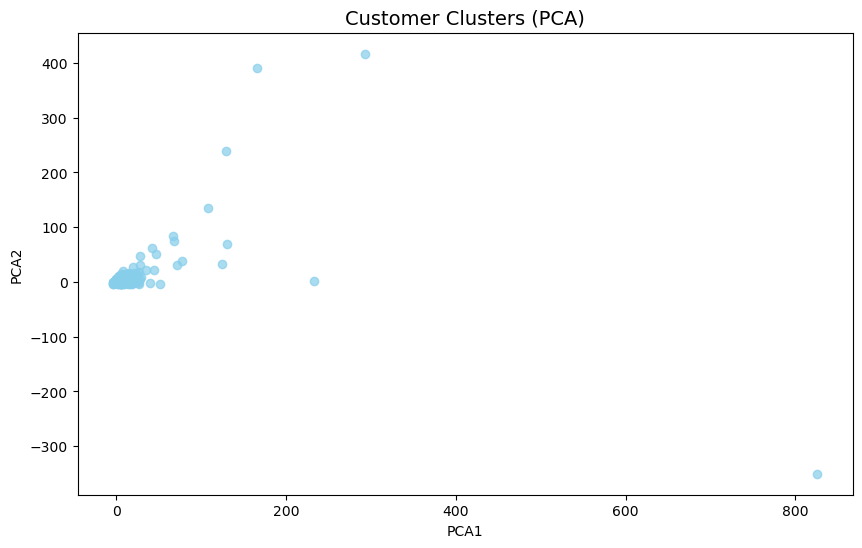

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a pivot table for customer-product interactions
pivot_df = df.pivot_table(index='CustomerID', columns='StockCode', values='TotalPrice', aggfunc='sum', fill_value=0)

# Ensure all column names are strings
pivot_df.columns = pivot_df.columns.astype(str)

# Normalize the data
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df)

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_scaled)

# Add PCA results to a DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CustomerID'] = pivot_df.index

# Visualize customer clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.7, color='skyblue')
plt.title('Customer Clusters (PCA)', fontsize=14)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


In [ ]:
# Enhance Recommendations with Contextual Features
# Example: Time-based recommendations
recent_purchases = df[df['InvoiceDate'] > '2011-11-01']
top_recent_products = recent_purchases.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False).head(5)
print(f"Top recent products: {top_recent_products}")

# Hybrid Recommendation System (Collaborative + Content-based)
# Add product metadata (mock example)
product_metadata = pd.DataFrame({
    'StockCode': ['85048', '71053', '84406B', '84406G', '22139'],
    'Description': ['Heart T-Light Holder', 'Mini Glass Bottles', 'Cream Coat Hanger', 'Knitted Cushion Cover', 'Vintage Blocks'],
    'Category': ['Decor', 'Decor', 'Furniture', 'Furniture', 'Toys']
})

# Merge product metadata with recommendations
merged_df = df.merge(product_metadata, on='StockCode', how='left')
print(merged_df.head())

# Save enhanced dataset for further analysis
merged_df.to_csv("Enhanced_OnlineRetail.csv", index=False)
print("Enhanced dataset saved!")


Top recent products: StockCode
23084     29998.85
22086     19893.48
85123A    15987.12
22423     14504.22
85099B    12520.03
Name: TotalPrice, dtype: float64
  InvoiceNo StockCode                        Description_x  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Year  Month  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  2010     12   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010     12   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  2010     12   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010     12   
4 2010-12-01 08:26:00  